In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

We define a "stock crash" as a huge daily change in price ( > 5 standard deviations from the mean over the last trading year).

We're applying the same method illustrated in Mandelbrot's "The Misbehaviour Of Markets" (2008, Mathematical appendix).

The goal is to show how unlikely a high price change is according to a normal distribution. This in turn provides evidence of the uselessness of using a normal distribution to quantify risk.

First some code to import prices for individual stocks from Yahoo.

In [3]:
 def import_stock_data(tickers, start = '2010-1-1'):
    """
    Imports data of a list of stocks from a certain date.
    
    Parameters
    ----------
    tickers : list of str
        List of tickers for stock prices
    start : str
        Date in yyyy-MM-dd format
        
    Returns
    -------
    pandas.DataFrame
    """
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        #data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

Import stocks data from Yahoo. We're considering the top 6 stocks according to https://it.marketscreener.com/quotazioni/indice/S-P-500-4985/composizione/ at the time of writing (18/10/2022). Berkshire Hathaway (BRK) is excluded because Yahoo failed to provided correct data for the stock.

In [9]:
stock = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'UNH']
data = import_stock_data(stock)
#stock = 'SPX'
#data = pd.DataFrame()
#data[stock] = pd.read_csv('./spx.csv')['Close/Last']

In [10]:
data.head()

,AAPL,MSFT,AMZN,TSLA,GOOGL,UNH
Date,,,,,,
2010-01-04,6.526021,23.749811,6.6950,NaN,15.684434,26.063278
2010-01-05,6.537305,23.757486,6.7345,NaN,15.615365,26.021942
2010-01-06,6.433319,23.611689,6.6125,NaN,15.221722,26.278198
2010-01-07,6.421424,23.366129,6.5000,NaN,14.867367,27.286674
2010-01-08,6.464117,23.527281,6.6760,NaN,15.065566,27.030420


Plot stocks price.

<AxesSubplot: xlabel='Date'>

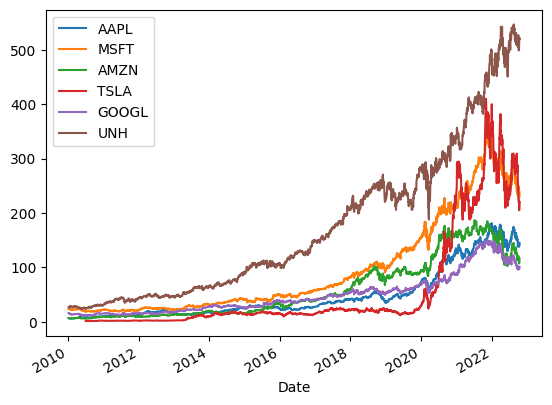

In [11]:
data[stock].plot()

Compute logarithm of prices and plot daily changes. We're interested in modeling price changes, not price itself.

<AxesSubplot: xlabel='Date'>

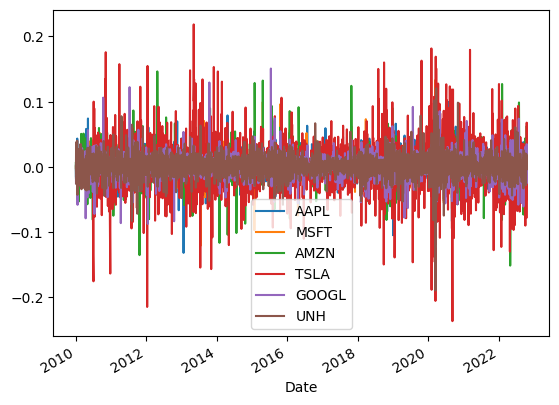

In [12]:
log_data = np.log(data[stock])
log_data_diff = log_data.diff()
log_data_diff.plot()

Define window length to be used in all subsequent computations. We consider mean, volatility, etc., over the course of one trading year (250 days).

In [14]:
window_length = 250

Compute mean.

<AxesSubplot: xlabel='Date'>

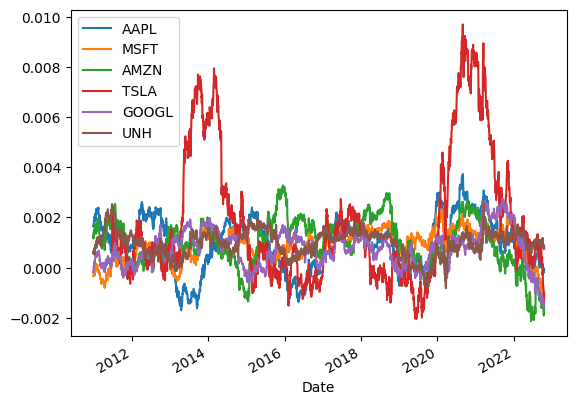

In [15]:
mean = log_data_diff.rolling(window_length).mean()
mean.plot()

Compute variance (as if it would fit the bell curve).

<AxesSubplot: xlabel='Date'>

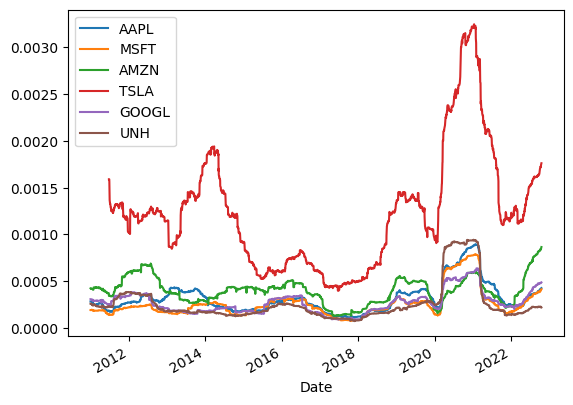

In [16]:
var = log_data_diff.rolling(window_length).var()
var.plot()

Compute standard deviation.

<AxesSubplot: xlabel='Date'>

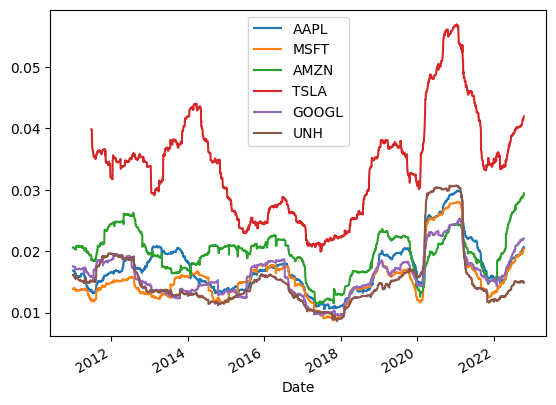

In [17]:
std = log_data_diff.rolling(window_length).std()
std.plot()

As we can see from this plots, variance varies wildly, with Tesla being the wildest.

Find number of standard deviations from the mean for each day (z-score). We start after the first year, minus one because we're dealing with price changes. z-score measures how much each day is distant from the mean, expressed in standard deviations over the previous year.

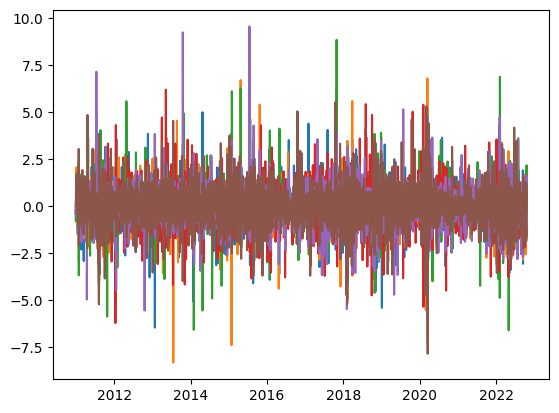

In [18]:
zscores = (log_data_diff[window_length-1:] - mean) / std
#zscores = st.zscore(log_data_diff.dropna().to_numpy())
plt.plot(zscores)

Find crashes (events with absolute high z-score, but in the negative).

In [19]:
crashes = pd.DataFrame() 
crashes[stock] = zscores[stock][zscores < -5]

Find probability of each crash. That is, getting a daily change as extreme as those in the data. We're considering those at least 5 standard deviations apart.

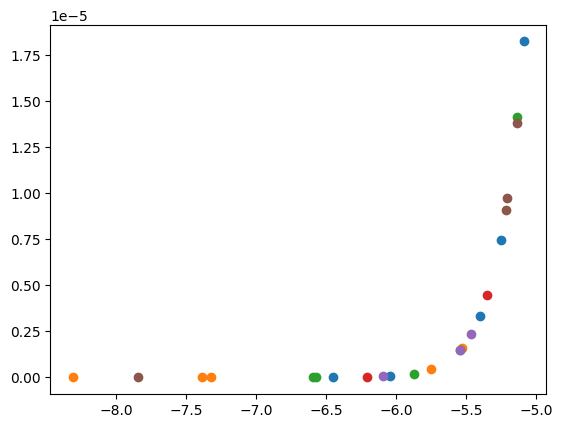

In [20]:
zscores_prob = pd.DataFrame()
zscores_prob[stock] = st.norm(0, 1).cdf(crashes)
for s in stock:
    plt.scatter(crashes[s], zscores_prob[s]*100) # percentage

If price changes really did follow a normal distributions, such crashes would be almost impossible (even considering the most probable, that's still a 0.0000175% probability of such a crash).